In [1]:

import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import flwr as fl
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from mlxtend.plotting import plot_confusion_matrix    
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = "./clientA/train"

# Path to validation directory
val_dir = "./clientA/val"

# Path to test directory
test_dir = "./clientA/test"

# Get the path to the normal and pneumonia sub-directories

normal_cases = glob.glob(train_dir +"/NORMAL"+"/*.jpeg")
pneumonia_cases= glob.glob(train_dir +"/PNEUMONIA"+"/*.jpeg")

# Get the list of all the images

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()


,image,label
0,./clientA/train/NORMAL\IM-0302-0001.jpeg,0
1,./clientA/train/NORMAL\IM-0475-0001.jpeg,0
2,./clientA/train/NORMAL\IM-0671-0001.jpeg,0
3,./clientA/train/PNEUMONIA\person958_virus_1630...,1
4,./clientA/train/PNEUMONIA\person537_bacteria_2...,1


In [2]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto,Session,get_default_graph
from tensorflow.random import set_seed
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
# Set the random seed in tensorflow at graph level
set_seed(111)

# Define a tensorflow session with above session configs
sess = Session(graph=get_default_graph())

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

tf.config.set_visible_devices(tf.config.list_physical_devices('GPU'), 'GPU')

1    2713
0     938
Name: label, dtype: int64


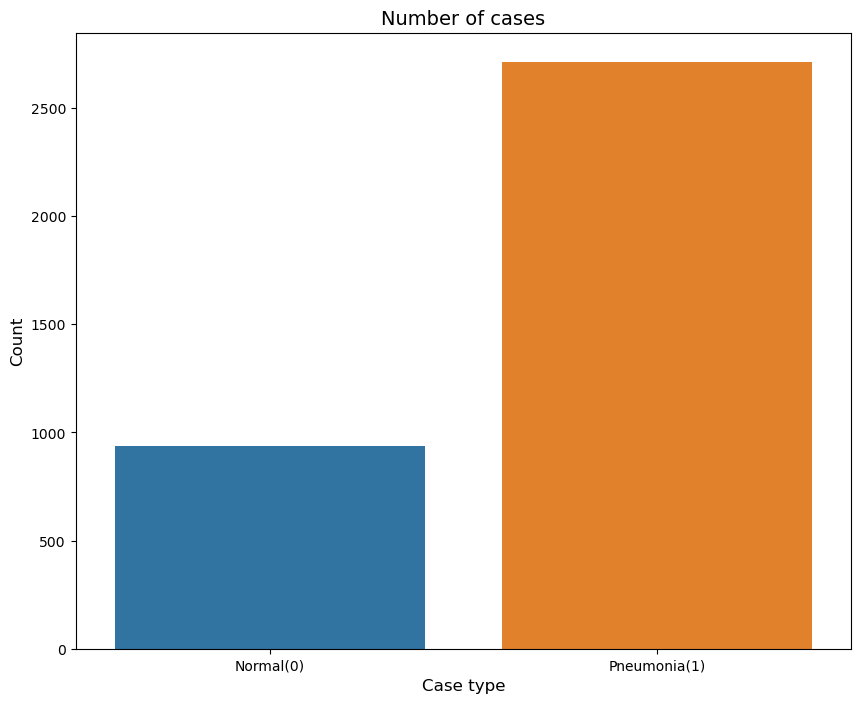

In [3]:
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [4]:
normal_dir=val_dir+"/NORMAL"
pneumonia_dir=val_dir+"/PNEUMONIA"

normal_cases = glob.glob(normal_dir+"/*.jpeg")
pneumonia_cases= glob.glob(pneumonia_dir+"/*.jpeg")
# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases

normal_cases=normal_cases[1:]
print(normal_cases)
pneumonia_cases=pneumonia_cases[1:]
print(pneumonia_cases)
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

['./clientA/val/NORMAL\\NORMAL2-IM-1431-0001.jpeg', './clientA/val/NORMAL\\NORMAL2-IM-1437-0001.jpeg', './clientA/val/NORMAL\\NORMAL2-IM-1438-0001.jpeg', './clientA/val/NORMAL\\NORMAL2-IM-1442-0001.jpeg']
['./clientA/val/PNEUMONIA\\person1949_bacteria_4880.jpeg', './clientA/val/PNEUMONIA\\person1951_bacteria_4882.jpeg', './clientA/val/PNEUMONIA\\person1952_bacteria_4883.jpeg', './clientA/val/PNEUMONIA\\person1954_bacteria_4886.jpeg']
Total number of validation examples:  (8, 224, 224, 3)
Total number of labels: (8, 2)


In [5]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [6]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [7]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model


In [8]:
model =  build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [9]:
# Open the VGG16 weight file
f = h5py.File('./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [10]:
opt = Adam(learning_rate=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [11]:
batch_size = 8
nb_epochs = 1

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))
len(train_data)

Number of training and validation steps: 456 and 8


3651

In [12]:
# # Fit the model
# history = model.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
#                               validation_data=(valid_data, valid_labels),callbacks=[es],
#                                class_weight={0:1.0, 1:0.4})

In [13]:
# Preparing test data
normal_dir=test_dir+"/NORMAL"
pneumonia_dir=test_dir+"/PNEUMONIA"

normal_cases = glob.glob(normal_dir+"/*.jpeg")
pneumonia_cases= glob.glob(pneumonia_dir+"/*.jpeg")

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else: 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (436, 224, 224, 3)
Total number of labels: (436, 2)


In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def get_parameters(self,config):
        return model.get_weights()

    def fit(self, parameters, config):
        model.set_weights(parameters)
        r = model.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es],
                               class_weight={0:1.0, 1:0.4})
        hist = r.history
        print("Fit history : " ,hist)
        results = {
            "loss": hist["loss"][0],
            "accuracy": hist["accuracy"][0],
            "val_loss": hist["val_loss"][0],
            "val_accuracy": hist["val_accuracy"][0],
        }
        return model.get_weights(), len(train_data), results

    def evaluate(self, parameters, config):
        model.set_weights(parameters)
        loss, accuracy = model.evaluate(test_data, test_labels, batch_size=8, verbose=0)
        print("Eval accuracy : ", accuracy)
        return loss, len(test_data), {"accuracy": accuracy}

# Start Flower client
fl.client.start_numpy_client(
        server_address="localhost:8080", 
        client=FlowerClient())

INFO flwr 2023-07-03 10:20:49,177 | grpc.py:50 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flwr 2023-07-03 10:20:49,196 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flwr 2023-07-03 10:20:49,205 | connection.py:39 | ChannelConnectivity.CONNECTING
DEBUG flwr 2023-07-03 10:20:49,209 | connection.py:39 | ChannelConnectivity.READY


456/456 [==============================] - 163s 266ms/step - loss: 0.0400 - accuracy: 0.9764 - val_loss: 0.1150 - val_accuracy: 1.0000
Fit history :  {'loss': [0.03995175659656525], 'accuracy': [0.9764254093170166], 'val_loss': [0.11502386629581451], 'val_accuracy': [1.0]}
Eval accuracy :  0.7683486342430115
